In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import time
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
#store = pd.HDFStore('X_pca.h5')
#X_pca = store['X_pca']

store = pd.HDFStore('X_pca.h5')
X_pca = store['X_pca']

store = pd.HDFStore('X_mob.h5')
X_mob = store['X_mob']

store = pd.HDFStore('X_month.h5')
X_month = store['X_month']

store = pd.HDFStore('X_year.h5')
X_year = store['X_year']

store = pd.HDFStore('y_default.h5')
y_default = store['y_default']

store = pd.HDFStore('y_prepay.h5')
y_prepay = store['y_prepay']

X_pca = X_pca.join(X_mob)
X_pca = X_pca.join(X_month)
X_pca = X_pca.join(X_year)

In [3]:
X_pca_add = X_pca[X_pca['mob']>2].copy()
X_pca_add['mob'] = np.floor(X_pca_add['mob']/2)
X_pca_add_half_sample = X_pca_add.sample(frac = 0.5)
X_pca = pd.concat([X_pca, X_pca_add_half_sample])

zeros = pd.DataFrame(np.zeros(X_pca_add_half_sample.shape[0]))
y_default = pd.concat([y_default,zeros])
y_prepay = pd.concat([y_prepay,zeros])

In [4]:
X_pca_add = X_pca[X_pca['mob']>4].copy()
X_pca_add['mob'] = np.ceil(X_pca_add['mob']/4*3)
X_pca_add_half_sample = X_pca_add.sample(frac = 0.5)
X_pca = pd.concat([X_pca, X_pca_add_half_sample])

zeros = pd.DataFrame(np.zeros(X_pca_add_half_sample.shape[0]))
y_default = pd.concat([y_default,zeros])
y_prepay = pd.concat([y_prepay,zeros])

In [5]:
X_pca_add = X_pca[X_pca['mob']>4].copy()
X_pca_add['mob'] = np.floor(X_pca_add['mob']/4)
X_pca_add_half_sample = X_pca_add.sample(frac = 0.5)
X_pca = pd.concat([X_pca, X_pca_add_half_sample])

zeros = pd.DataFrame(np.zeros(X_pca_add_half_sample.shape[0]))
y_default = pd.concat([y_default,zeros])
y_prepay = pd.concat([y_prepay,zeros])

In [6]:
X_pca

,0,1,2,3,4,5,6,7,8,9,10,mob,Orig_month,Orig_year
0,0.717521,-0.458524,1.433562,1.046494,0.164595,-0.072055,-0.030477,-0.168625,-0.026212,0.399204,-0.980749,45.0,4,2016
1,2.244616,-1.030425,-2.443468,-0.576140,0.748542,-0.115527,1.318192,0.025524,0.144284,-0.892829,0.537241,36.0,5,2016
2,0.310954,0.027425,-1.540056,0.840923,-0.836991,-0.101286,0.769092,0.116545,0.204194,-0.554330,0.878635,36.0,4,2016
3,0.383023,-1.832473,-0.242715,0.706981,-0.896038,0.766941,0.857497,0.164902,0.243484,-0.455246,1.471685,37.0,5,2016
4,2.691928,1.549250,1.128812,1.238563,-0.146378,0.364322,1.418887,-0.103755,0.294065,-0.282789,-1.066466,36.0,6,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207730,0.338046,0.315498,-0.284876,1.700593,-0.868347,0.170940,0.765469,0.106267,0.210860,-0.419330,0.873786,2.0,9,2018
48313,4.526600,0.048939,-1.500917,-2.279047,0.556119,-0.762716,-0.128272,-0.065175,-0.091386,-0.141838,-0.761191,2.0,11,2017
524849,-0.418536,-4.066177,0.243848,-1.071754,-0.968233,-0.326652,-0.268173,-0.033324,0.135863,0.459662,-0.485221,2.0,2,2017
577507,-3.848231,-3.144387,1.255373,-0.020081,1.663337,-1.575519,1.023812,0.095469,-0.105174,-1.015386,0.252354,1.0,6,2016


In [7]:
trainX, testX, trainy, testy = train_test_split(X_pca, y_default, test_size=0.2, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


No Skill: ROC AUC=0.500
RandomForestClassifier: ROC AUC=0.785


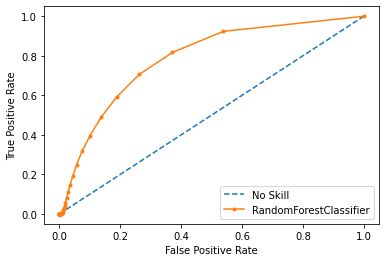

489.2439556121826 s


In [8]:
time_start = time.time()
model = RandomForestClassifier(n_estimators=50,random_state=0)
model.fit(trainX, trainy)
time_end = time.time()

# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('RandomForestClassifier: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='RandomForestClassifier')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

print (time_end - time_start, "s")

In [6]:
trainX, testX, trainy, testy = train_test_split(X_pca, y_prepay, test_size=0.2, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]

In [7]:
time_start = time.time()
model = RandomForestClassifier(n_estimators=50,random_state=0)
model.fit(trainX, trainy)
time_end = time.time()

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


No Skill: ROC AUC=0.500
RandomForestClassifier: ROC AUC=0.734


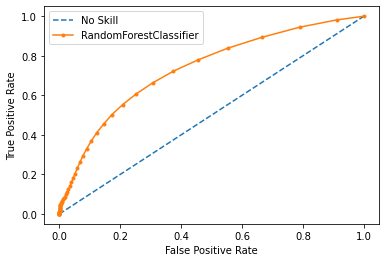

545.2861704826355 s


In [8]:
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('RandomForestClassifier: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='RandomForestClassifier')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
print (time_end - time_start, "s")